In [1]:
from __future__ import print_function
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision import models, transforms
import os
import numpy as np
import sys

from torchvision.datasets import VisionDataset
from torchvision.datasets.utils import check_integrity #, download_and_extract_archive
import pandas
import csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import time
import copy

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [2]:
sys.path.append(os.path.expanduser("~/few-shot-learning/"))
from few_shot.datasets import FashionProductImages

In [ ]:
fashion = FashionProductImages("~/data", classes="top", split="train", transform=data_transforms["train"])

X, y = fashion[10]
# X, y = fashion[10:15] # fails

len(fashion)

for i in range(len(fashion)):
    X, y = fashion[i]
    # print(y.shape)
    # if not isinstance(y, int):
    #    import pdb; pdb.set_trace()
    if not (X.shape[1]==80 and X.shape[2]==60):
        import pdb; pdb.set_trace()

counter = 0
for (i, batch) in enumerate(train_loader):
    counter += 64
    print(counter)
    # import pdb; pdb.set_trace()
    
    

In [ ]:
class_sample_count = np.bincount(fashion.target_indices, minlength=fashion.n_classes)
print(class_sample_count)
print(len(class_sample_count))
print(sum(class_sample_count))

print(np.unique(fashion.targets))
print(len(np.unique(fashion.targets)))

print(np.unique(fashion.df_meta["articleType"]))
print(len(np.unique(fashion.df_meta["articleType"])))

# all perfumes are from 2017, which means they're all in the test set
fashion.df_meta[
    (fashion.df_meta["articleType"]=="Perfume and Body Mist")
     & (fashion.df_meta["year"] == 2017.0)
]

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((80,60), scale=(0.8, 1.0)),
        # transforms.Resize((80,60)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((80,60)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((80,60)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

datasets = {
    classes: {
        split: FashionProductImages(
            "~/data",
            split='train' if split in ['train', 'val'] else 'test',
            classes=classes,
            transform=data_transforms[split]
        ) for split in ["train", "test", "val"]
    } for classes in ["top", "bottom"]
}

In [5]:
def get_train_and_val_sampler(trainset, train_size=0.9, balanced_training=True, stratify=True):
    n_classes = trainset.n_classes
    n_samples = len(trainset)
    indices = np.arange(n_samples)
    labels = trainset.target_indices
    
    train_indices, val_indices = train_test_split(
        indices, train_size=0.9,
        stratify=trainset.target_indices if stratify else None
    )
    
    val_sampler = SubsetRandomSampler(val_indices)
    
    if balanced_training:
        class_sample_count = np.bincount(labels[train_indices], minlength=n_classes)
        class_sample_count = torch.from_numpy(class_sample_count).float()

        class_weights = torch.zeros_like(class_sample_count)
        class_weights[class_sample_count > 0] = 1./class_sample_count[class_sample_count > 0]

        train_weights = class_weights[labels[train_indices]]
        dataset_weights = torch.zeros(n_samples)
        dataset_weights[train_indices] = train_weights
        
        # TODO: in this way, train_loader will still produce n_samples samples per epoch
        # (instead of train_size*n_samples)
        train_sampler = WeightedRandomSampler(dataset_weights, n_samples, replacement=True)
    else:
        train_sampler = SubsetRandomSampler(train_indices)
        
    return train_sampler, train_indices, val_sampler, val_indices

In [6]:
batch_size = 64

# train_size = int(len(fashion) * 0.9)
# trainset, valset = random_split(fashion, [train_size, len(fashion) - train_size])
trainset = datasets['top']['train']
valset = datasets['top']['val']

train_sampler, train_indices, val_sampler, val_indices = get_train_and_val_sampler(trainset, balanced_training=True)

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=4, sampler=train_sampler)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=4, sampler=val_sampler)

dataloaders = {"train": train_loader, "val": val_loader}
# dataset_sizes = {"train": len(train_indices), "val": len(val_indices)}

In [6]:
y_counts = np.zeros(trainset.n_classes)

for batch in train_loader:
    X, y = batch
    y_counts += np.bincount(y, minlength=20)
    
print(y_counts)
print(y_counts / y_counts.sum())
print(y_counts.sum())

y_counts = np.zeros(valset.n_classes)

for batch in val_loader:
    X, y = batch
    y_counts += np.bincount(y, minlength=20)
    
print(y_counts)
print(y_counts / y_counts.sum())
print(y_counts.sum())

[ 947.  977.  948.  967.  957.  928.  908.  929.  878.  971.    0.  943.
 1007. 1000.  932.  972.  965.  897.  968.  906.]
[0.05261111 0.05427778 0.05266667 0.05372222 0.05316667 0.05155556
 0.05044444 0.05161111 0.04877778 0.05394444 0.         0.05238889
 0.05594444 0.05555556 0.05177778 0.054      0.05361111 0.04983333
 0.05377778 0.05033333]
18000.0
[ 25.  49.  66. 155.  51.  36. 101.  77.  34. 114.   0.  48. 113.  50.
  88. 104. 106. 275.  60. 248.]
[0.01388889 0.02722222 0.03666667 0.08611111 0.02833333 0.02
 0.05611111 0.04277778 0.01888889 0.06333333 0.         0.02666667
 0.06277778 0.02777778 0.04888889 0.05777778 0.05888889 0.15277778
 0.03333333 0.13777778]
1800.0


In [7]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    dataset_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
    
    n_classes = dataloaders['train'].dataset.n_classes

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # TODO.refactor
            running_confusion_matrix = np.zeros([model.fc.out_features]*2)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # multiply batch loss with batch_size to go from mean to sum
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_confusion_matrix += confusion_matrix(labels.cpu(), preds.cpu(), labels=np.arange(n_classes))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_conf_matrix = running_confusion_matrix.copy()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_conf_matrix = epoch_conf_matrix.copy()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, best_conf_matrix

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True)
# model_ft = models.resnet50(pretrained=True)

num_ftrs = model_ft.fc.in_features
# Alternatively: nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, trainset.n_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5)

In [10]:
model_ft, conf_matrix = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler,
    dataloaders, num_epochs=100
)

Epoch 1/100
----------
train Loss: 0.5853 Acc: 0.8067
val Loss: 0.4175 Acc: 0.8522

Epoch 2/100
----------
train Loss: 0.3727 Acc: 0.8752
val Loss: 0.3861 Acc: 0.8594

Epoch 3/100
----------
train Loss: 0.3087 Acc: 0.8944
val Loss: 0.4481 Acc: 0.8467

Epoch 4/100
----------
train Loss: 0.2632 Acc: 0.9091
val Loss: 0.3006 Acc: 0.8889

Epoch 5/100
----------
train Loss: 0.2610 Acc: 0.9090
val Loss: 0.3676 Acc: 0.8706

Epoch 6/100
----------
train Loss: 0.1890 Acc: 0.9338
val Loss: 0.2332 Acc: 0.9156

Epoch 7/100
----------
train Loss: 0.1787 Acc: 0.9378
val Loss: 0.2316 Acc: 0.9167

Epoch 8/100
----------
train Loss: 0.1593 Acc: 0.9424
val Loss: 0.2203 Acc: 0.9200

Epoch 9/100
----------
train Loss: 0.1556 Acc: 0.9433
val Loss: 0.2379 Acc: 0.9200

Epoch 10/100
----------
train Loss: 0.1570 Acc: 0.9441
val Loss: 0.2496 Acc: 0.9178

Epoch 11/100
----------
train Loss: 0.1252 Acc: 0.9547
val Loss: 0.2025 Acc: 0.9244

Epoch 12/100
----------
train Loss: 0.1178 Acc: 0.9569
val Loss: 0.2172 Ac

val Loss: 0.2201 Acc: 0.9383

Epoch 98/100
----------
train Loss: 0.0372 Acc: 0.9867
val Loss: 0.2189 Acc: 0.9400

Epoch 99/100
----------
train Loss: 0.0360 Acc: 0.9877
val Loss: 0.2217 Acc: 0.9372

Epoch 100/100
----------
train Loss: 0.0397 Acc: 0.9861
val Loss: 0.2248 Acc: 0.9372

Training complete in 45m 44s
Best val Acc: 0.941111


In [11]:
conf_matrix.sum()

1800.0

In [16]:
batch_size = 64

# now prepare training sets of the remaining (bottom) classes
trainset_tr = datasets['bottom']['train']
valset_tr = datasets['bottom']['val']

# can't stratify along classes since some have only one sample
train_tr_sampler, train_tr_indices, val_tr_sampler, val_tr_indices = \
    get_train_and_val_sampler(trainset_tr, balanced_training=True, stratify=False)

train_tr_loader = DataLoader(
    trainset_tr, batch_size=batch_size, num_workers=4, sampler=train_tr_sampler)
val_tr_loader = DataLoader(
    valset_tr, batch_size=batch_size, num_workers=4, sampler=val_tr_sampler)

dataloaders = {"train": train_tr_loader, "val": val_tr_loader}
# dataset_sizes = {"train": len(train_tr_indices), "val": len(val_tr_indices)}

# instaniate resnet again
model_tr = models.resnet18(pretrained=True)

# modify output layer
model_tr.fc = nn.Linear(model_ft.fc.in_features, model_ft.fc.out_features)

# copy fine tuned network weights
model_tr.load_state_dict(copy.deepcopy(model_ft.state_dict()))

# freeze all lower layers of the network
# for param in model_tr.parameters():
#     param.requires_grad = False
    
# adapt final layer fully-connected layer (unfrozen)
model_tr.fc = nn.Linear(num_ftrs, trainset_tr.n_classes)

model_tr.to(device)

# Observe that all parameters are being optimized
optimizer_tr = optim.Adam(model_tr.parameters(), lr=1e-4, betas=(0.9, 0.999))

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_tr = optim.lr_scheduler.StepLR(optimizer_tr, step_size=10, gamma=0.5)

In [15]:
del model_tr

In [17]:
model_tr, conf_matrix_tr= train_model(
    model_tr, criterion, optimizer_tr, exp_lr_scheduler_tr,
    dataloaders, num_epochs=100
)

Epoch 1/100
----------
train Loss: 3.4881 Acc: 0.2882
val Loss: 2.7145 Acc: 0.3109

Epoch 2/100
----------
train Loss: 1.7372 Acc: 0.6217
val Loss: 1.7166 Acc: 0.5285

Epoch 3/100
----------
train Loss: 1.0816 Acc: 0.7309
val Loss: 1.2812 Acc: 0.6477

Epoch 4/100
----------
train Loss: 0.7437 Acc: 0.8099
val Loss: 1.1193 Acc: 0.6770

Epoch 5/100
----------
train Loss: 0.5590 Acc: 0.8521
val Loss: 0.9393 Acc: 0.7150

Epoch 6/100
----------
train Loss: 0.4514 Acc: 0.8747
val Loss: 0.9307 Acc: 0.7150

Epoch 7/100
----------
train Loss: 0.3547 Acc: 0.9003
val Loss: 0.8502 Acc: 0.7340

Epoch 8/100
----------
train Loss: 0.3135 Acc: 0.9119
val Loss: 0.7801 Acc: 0.7686

Epoch 9/100
----------
train Loss: 0.2599 Acc: 0.9271
val Loss: 0.7820 Acc: 0.7651

Epoch 10/100
----------
train Loss: 0.2375 Acc: 0.9300
val Loss: 0.7815 Acc: 0.7668

Epoch 11/100
----------
train Loss: 0.2099 Acc: 0.9378
val Loss: 0.7713 Acc: 0.7703

Epoch 12/100
----------
train Loss: 0.2071 Acc: 0.9426
val Loss: 0.7466 Ac

val Loss: 0.7054 Acc: 0.7997

Epoch 98/100
----------
train Loss: 0.1475 Acc: 0.9566
val Loss: 0.7118 Acc: 0.7979

Epoch 99/100
----------
train Loss: 0.1534 Acc: 0.9575
val Loss: 0.7124 Acc: 0.7979

Epoch 100/100
----------
train Loss: 0.1623 Acc: 0.9547
val Loss: 0.7072 Acc: 0.7927

Training complete in 15m 22s
Best val Acc: 0.803109


In [24]:
conf_matrix_tr

array([[ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [25]:
import matplotlib.pyplot as plt

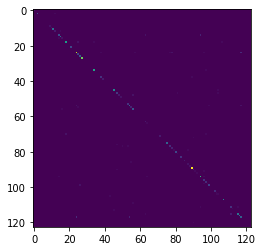

In [26]:
plt.imshow(conf_matrix_transfer)

In [27]:
conf_matrix_transfer.sum()

579.0

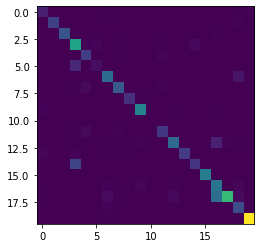

In [28]:
plt.imshow(conf_matrix)